In [1]:
import numpy as np
import matplotlib.pyplot as plt

import importlib
import os, sys
sys.path.append(os.path.abspath(".."))

In [2]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.bs
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.bs)
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

# The Double Heston Model

In the Double Heston model, the asset is assumed to follow the dynamics given by these equations
$$\begin{align} \frac{d S_t}{S_t} & = r dt + \sqrt{v_1} d W_t^1 + \sqrt{v_2} dW_t^2 \\
d V_t^1 & = \kappa_1 (\theta_1 - v_1) dt + \sigma_1 \sqrt{v1} d Z_t^1 \\
dV_t^2 & = \kappa_2 (\theta_2-v_t^2) dt + \sigma_2 \sqrt{v_t^2} d Z_t^2\end{align} $$ with the following stochastic structure 
$$ \begin{align} \langle dW^1, dZ^1 \rangle_t & = \rho_1 dt \\
\langle dW^2, dZ^2 \rangle_t &= \rho_2 dt \\
\langle dW^1, dW^2 \rangle_t &= 0 \\
\langle dZ^1, dZ^2 \rangle_t &= 0
\end{align} $$

The discretization of these equations is not trivial. My implementation follows the scheme introduced in the paper *Efficient Simulation of the Double Heston model* by Gauthier and Possamai, 2010.The derivation of the scheme with some adaptations to make it self-contained and transparent is presented at the end of this notebook. 

One of the main advantages of the Double Heston model is that it remains analytically tractable, like the standard Heston model, but it requires additional mathematical machinery. For my implementation, I followed the derivation of the characteristic functions presented in *The Heston Model and its Extensions in Matlab and C#* by Rouah (2013), and implemented the formulas myself. The implementation also uses the Heston trap for numerical stability.


## 1. Monte Carlo Price Convergence

Let us first see that the calculated price using Monte Carlo for the discretization from Gauthier and Possamai behaves as theory predicts (error decay like $1/\sqrt{N}$), where $N$ is the number of paths. I first calculate the exact price using the implementation of the analytical formula in the DoubleHeston class and plot the absolute errors for the average of increasing number of paths. Additionally, I calculate a high precision estimate of the Monte Carlo price using the average of 6 runs of the MC price with one million paths and plot the absolute errors for this reference value. 

I assume that the Double Heston model has parameters $$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and consider an option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$. These parameters will be the same in the rest of the experiments

CF price:  19.453781506697773

Computing MC price reference using a large number of paths...
Computed MC price reference. Repetition: 1/5.
Computed MC price reference. Repetition: 2/5.
Computed MC price reference. Repetition: 3/5.
Computed MC price reference. Repetition: 4/5.
Computed MC price reference. Repetition: 5/5.
MC price reference using a large number of paths (discretization-biased): 19.585406896656384
Running MC convergence test for smaller N_paths...
MC paths=   100 → mean=19.286467, std=4.030025 | diff from CF=-0.167315 | diff from ref MC=-0.298940
MC paths=   400 → mean=19.722274, std=2.257528 | diff from CF=0.268493 | diff from ref MC=0.136867
MC paths=  1600 → mean=19.746318, std=1.192834 | diff from CF=0.292537 | diff from ref MC=0.160911
MC paths=  6400 → mean=19.519646, std=0.547967 | diff from CF=0.065865 | diff from ref MC=-0.065761
MC paths= 25600 → mean=19.552793, std=0.276173 | diff from CF=0.099011 | diff from ref MC=-0.032614
MC paths=102400 → mean=19.601418, 

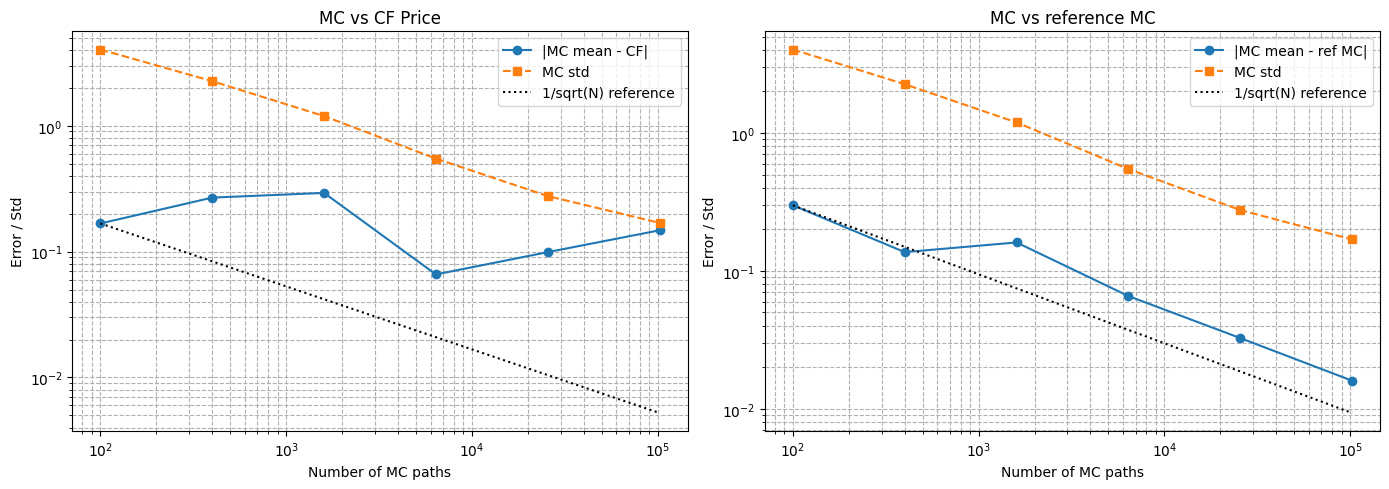

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import models.doubleheston  

# ----------------------
# Model & parameters
# ----------------------
DoubleHeston_ref = models.doubleheston.DoubleHeston(
    r=0.03, q=0.0, kappa1=0.9, kappa2=1.2,
    theta1=0.1, theta2=0.15, sigma1=0.1, sigma2=0.2,
    rho1=-0.5, rho2=-0.5
)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# MC parameters
N_steps = 252
mc_sizes = [4**i*100 for i in range(6)]
n_repeats = 50
N_paths_large = int(1e6)
n_repeats_large = 5

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "mc_convergence_results.npz")

# ----------------------
# Compute CF price (always cheap)
# ----------------------
S = np.array([[S0]])
V1 = np.array([[v01]])
V2 = np.array([[v02]])
Tau = np.array([[T]])

greeks_cf = DoubleHeston_ref.price_greeks_vect(
    K=K, Tau=Tau, S=S, V1=V1, V2=V2,
    quad_rule='laguerre', quad_params={'nodes':64}
)
cf_price = greeks_cf["Price_call"][0,0]
print("CF price: ", cf_price)
print()

# ----------------------
# Check if cached results exist and match parameters
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()  # stored as dict
    if (cached_params.get('N_steps') == N_steps and
        cached_params.get('n_repeats') == n_repeats and
        cached_params.get('N_paths_large') == N_paths_large and
        cached_params.get('n_repeats_large') == n_repeats_large):
        print("Cached results match parameters. Loading...")
        npaths_arr = data['npaths_arr']
        mean_mc_arr = data['mean_mc_arr']
        std_mc_arr  = data['std_mc_arr']
        mc_ref      = data['mc_ref'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing MC...")

if recompute:
    # ----------------------
    # Large N_paths reference
    # ----------------------
    print("Computing MC price reference using a large number of paths...")
    mc_large_estimates = []
    for rep in range(n_repeats_large):
        mc_price = DoubleHeston_ref.mc_price(
            K=K, T=T, S0=S0, v01=v01, v02=v02,
            N_paths=N_paths_large, N_steps=N_steps, seed=rep
        )
        mc_large_estimates.append(mc_price)
        print(f"Computed MC price reference. Repetition: {rep+1}/{n_repeats_large}.")
    mc_ref = np.mean(mc_large_estimates)
    print("MC price reference using a large number of paths (discretization-biased):", mc_ref)

    # ----------------------
    # MC convergence test
    # ----------------------
    print("Running MC convergence test for smaller N_paths...")
    mc_results = []
    for npaths in mc_sizes:
        mc_estimates = []
        for rep in range(n_repeats):
            mc_price = DoubleHeston_ref.mc_price(
                K=K, T=T, S0=S0, v01=v01, v02=v02,
                N_paths=npaths, N_steps=N_steps, seed=rep
            )
            mc_estimates.append(mc_price)
        mc_estimates = np.array(mc_estimates)
        mean_mc = mc_estimates.mean()
        std_mc  = mc_estimates.std(ddof=1)
        mc_results.append((npaths, mean_mc, std_mc))
        print(f"MC paths={npaths:6d} → mean={mean_mc:.6f}, std={std_mc:.6f} | diff from CF={mean_mc - cf_price:.6f} | diff from ref MC={mean_mc - mc_ref:.6f}")

    mc_results = np.array(mc_results)
    npaths_arr = mc_results[:,0]
    mean_mc_arr = mc_results[:,1]
    std_mc_arr = mc_results[:,2]

    # Save results + parameters
    params = {
        'N_steps': N_steps,
        'n_repeats': n_repeats,
        'N_paths_large': N_paths_large,
        'n_repeats_large': n_repeats_large
    }
    np.savez_compressed(
        filename,
        npaths_arr=npaths_arr,
        mean_mc_arr=mean_mc_arr,
        std_mc_arr=std_mc_arr,
        cf_price=cf_price,
        mc_ref=mc_ref,
        params=params
    )
    print(f"MC convergence results saved to '{filename}'")

# ----------------------
# Plot side by side
# ----------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1) MC vs CF
error_cf = np.abs(mean_mc_arr - cf_price)
axes[0].loglog(npaths_arr, error_cf, 'o-', label='|MC mean - CF|')
axes[0].loglog(npaths_arr, std_mc_arr, 's--', label='MC std')
axes[0].loglog(npaths_arr, 1/np.sqrt(npaths_arr)*error_cf[0]*np.sqrt(npaths_arr[0]), 'k:', label='1/sqrt(N) reference')
axes[0].set_xlabel('Number of MC paths')
axes[0].set_ylabel('Error / Std')
axes[0].set_title('MC vs CF Price')
axes[0].legend()
axes[0].grid(True, which='both', ls='--')

# 2) MC vs Large-path MC reference
error_ref = np.abs(mean_mc_arr - mc_ref)
axes[1].loglog(npaths_arr, error_ref, 'o-', label='|MC mean - ref MC|')
axes[1].loglog(npaths_arr, std_mc_arr, 's--', label='MC std')
axes[1].loglog(npaths_arr, 1/np.sqrt(npaths_arr)*error_ref[0]*np.sqrt(npaths_arr[0]), 'k:', label='1/sqrt(N) reference')
axes[1].set_xlabel('Number of MC paths')
axes[1].set_ylabel('Error / Std')
axes[1].set_title('MC vs reference MC')
axes[1].legend()
axes[1].grid(True, which='both', ls='--')

plt.tight_layout()
fig.savefig(os.path.join(results_folder, "mc_convergence_plot.png"))
plt.show()


As we can see, the error an variance do follow the predicted $1/\sqrt{N}$ once the bias of the Euler discretization is accounted for.

## 2. Hedging under risk-free and general drifts

This experiment shows the results of hedging under the risk-neutral and general drifts. We take $\mu=r=0.03$ as the risk-free drift and $\mu=0.23$ for comparison. The Double Heston model is assumed to have parameters 
$$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and we consider a call option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$.


Found cached results '../results/hedging_dh_results.npz' — checking parameters...
Cached results match parameters. Loading...


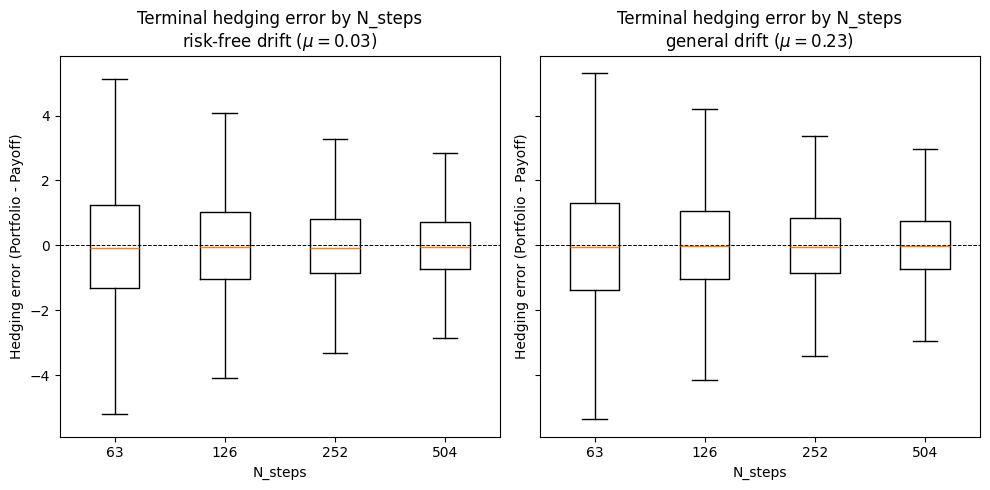

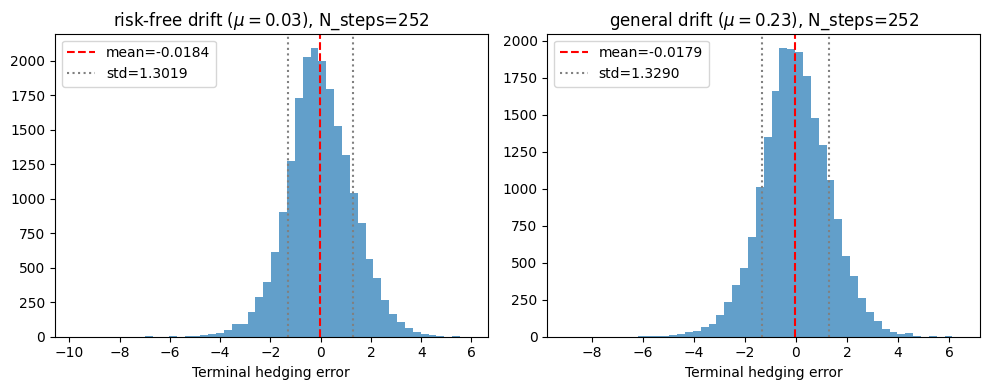

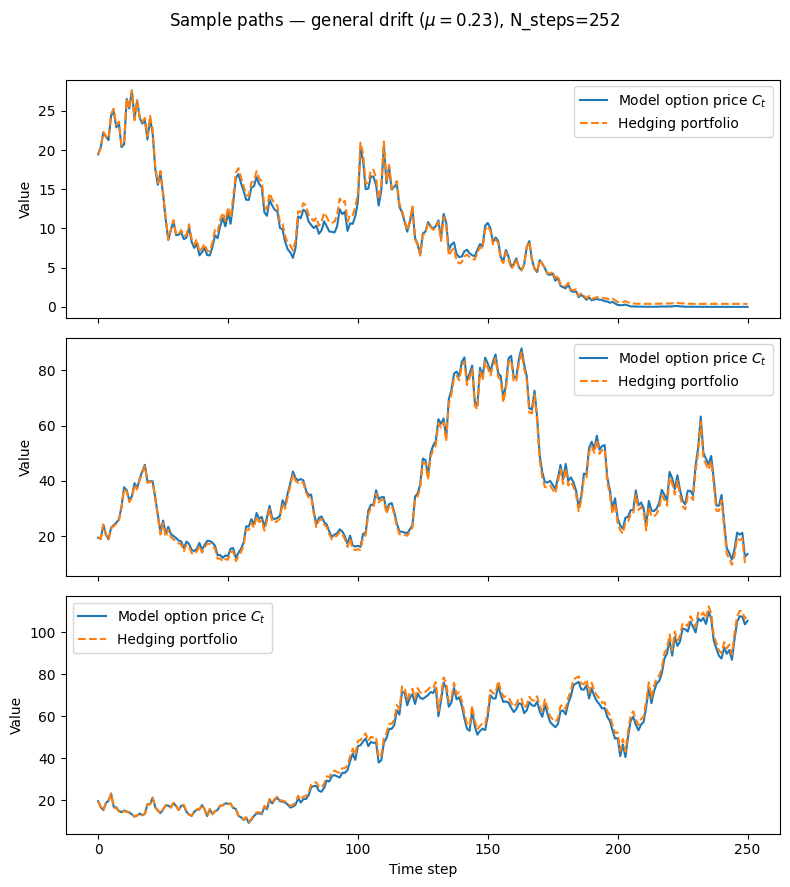


Summary table (mean, std of terminal hedging error):

Scenario: risk-free drift (µ=0.03)
  N_steps= 63  mean=-0.045739  std= 2.126140
  N_steps=126  mean=-0.007004  std= 1.639822
  N_steps=252  mean=-0.018359  std= 1.301911
  N_steps=504  mean= 0.004140  std= 1.094891

Scenario: general drift (µ=0.23)
  N_steps= 63  mean=-0.051229  std= 2.181273
  N_steps=126  mean=-0.008383  std= 1.664875
  N_steps=252  mean=-0.017866  std= 1.328983
  N_steps=504  mean= 0.001483  std= 1.130793


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import models.doubleheston
import utils.hedging

# ----------------------
# Model & parameters
# ----------------------
DoubleHeston_ref = models.doubleheston.DoubleHeston(
    r=0.03, q=0.0,
    kappa1=0.9, kappa2=1.2,
    theta1=0.1, theta2=0.15,
    sigma1=0.1, sigma2=0.2,
    rho1=-0.5, rho2=-0.5
)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# Hedging experiment parameters
N_paths = 20000
nsteps_list = [63*2**i for i in range(4)]
seed = 20

# Quadrature
quad_rule = 'laguerre'
quad_params = {'nodes': 32}

# Drift scenarios
scenarios = {
    "risk-free drift": DoubleHeston_ref.r,
    "general drift": DoubleHeston_ref.r + 0.2
}

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "hedging_dh_results.npz")

# ----------------------
# Check if cached results exist
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()
    if (cached_params.get('N_paths') == N_paths and
        cached_params.get('nsteps_list') == nsteps_list and
        cached_params.get('seed') == seed):
        print("Cached results match parameters. Loading...")
        results = data['results'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing...")

if recompute:
    results = {}
    for scen_name, mu in scenarios.items():
        results[scen_name] = {}
        print(f"\n--- Scenario: {scen_name} (mu = {mu:.4f}) ---")
        for N_steps in nsteps_list:
            print(f"Running delta hedge: N_paths={N_paths}, N_steps={N_steps} ...", end="", flush=True)
            out = utils.hedging.delta_hedge(
                model=DoubleHeston_ref, mu=mu, K=K, T=T, S0=S0,
                v01=v01, v02=v02,
                N_paths=N_paths, N_steps=N_steps, seed=seed,
                quad_rule=quad_rule, quad_params=quad_params
            )
            hed_err = out['hedging_error_T']
            mean_err = np.mean(hed_err)
            std_err = np.std(hed_err)
            results[scen_name][N_steps] = {
                'out': out,
                'mean': mean_err,
                'std': std_err,
                'hed_err': hed_err
            }
            print(f" done. mean={mean_err:.6f}, std={std_err:.6f}")

    # Save results + parameters
    params = {
        'N_paths': N_paths,
        'nsteps_list': nsteps_list,
        'seed': seed
    }
    np.savez_compressed(filename, results=results, params=params)
    print(f"\nHedging results saved to '{filename}'")

# ----------------------
# Plots and summaries
# ----------------------

# 1) Boxplot of terminal hedging error vs rebalancing frequency
fig, axes = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios), 5), sharey=True)
if len(scenarios) == 1:
    axes = [axes]
for ax, (scen_name, dic) in zip(axes, results.items()):
    data = [dic[n]['hed_err'] for n in nsteps_list]
    ax.boxplot(data, tick_labels=[str(n) for n in nsteps_list], showfliers=False)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.7)
    ax.set_title("Terminal hedging error by N_steps\n"+f"{scen_name} ($\mu= {scenarios[scen_name]}$)")
    ax.set_xlabel("N_steps")
    ax.set_ylabel("Hedging error (Portfolio - Payoff)")
plt.tight_layout()
fig.savefig(os.path.join(results_folder, "hedging_dh_boxplot.png"))
plt.show()

# 2) Histogram of terminal hedging error for middle N_steps
chosen_n = nsteps_list[-2]
fig, axes = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios), 4))
if len(scenarios) == 1:
    axes = [axes]
for ax, (scen_name, dic) in zip(axes, results.items()):
    hed = dic[chosen_n]['hed_err']
    ax.hist(hed, bins=50, density=False, alpha=0.7)
    ax.axvline(np.mean(hed), color='red', linestyle='--', label=f"mean={np.mean(hed):.4f}")
    ax.axvline(np.mean(hed)+np.std(hed), color='gray', linestyle=':', label=f"std={np.std(hed):.4f}")
    ax.axvline(np.mean(hed)-np.std(hed), color='gray', linestyle=':')
    ax.set_title(f"{scen_name} ($\mu= {scenarios[scen_name]}$), N_steps={chosen_n}")
    ax.set_xlabel("Terminal hedging error")
    ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(results_folder, f"hedging_dh_hist_N{chosen_n}.png"))
plt.show()

# 3) Sample path plots: option price vs hedging portfolio
example_scenario = 'general drift'
example_N = nsteps_list[-2]
ex = results[example_scenario][example_N]['out']
S = ex['S']
Price_call = ex['Price_call']
Portfolio = ex['Portfolio']

chosen_paths = [24, 165, 55] 
n_show = len(chosen_paths)#min(3, N_paths)
fig, axes = plt.subplots(n_show, 1, figsize=(8, 3*n_show), sharex=True)
threshold = 1e-4  # defines what price of call is "effectively zero" for plotting purposes
for i, path_idx in enumerate(chosen_paths): 
    price_line = Price_call[path_idx,:].copy()
    zero_start = np.argmax(price_line < threshold) if np.any(price_line < threshold) else len(price_line)
    price_line[zero_start:] = 0.0
    axes[i].plot(price_line[:-1], label='Model option price $C_t$')
    #axes[i].plot(Price_call[path_idx,:], label='Model option price $C_t$')
    axes[i].plot(Portfolio[path_idx,:-1], '--', label='Hedging portfolio')
    axes[i].set_ylabel("Value")
    axes[i].legend()
axes[-1].set_xlabel("Time step")
plt.suptitle(f"Sample paths — {example_scenario} ($\mu= {scenarios[example_scenario]}$), N_steps={example_N}")
plt.tight_layout(rect=[0,0,1,0.96])
fig.savefig(os.path.join(results_folder, f"hedging_dh_paths_{example_scenario}_N{example_N}.png"))
plt.show()

# 4) Summary table
print("\nSummary table (mean, std of terminal hedging error):")
for scen_name, dic in results.items():
    print(f"\nScenario: {scen_name} (µ={scenarios[scen_name]})")
    for N_steps in nsteps_list:
        mean_err = dic[N_steps]['mean']
        std_err = dic[N_steps]['std']
        print(f"  N_steps={N_steps:3d}  mean={mean_err: .6f}  std={std_err: .6f}")

From the plots we can see that in both the risk-free and general drift the hedging errors have means close to zero and that the dispersion of these errors decrease as the rebalancing of the portfolio increases. Even in the general drift case, the portfolio is able to replicate the price of the option very closely, as shown in the plot containing a selection of hedging paths.

The following experiment shows that for moderate values of $\mu$ ($\mu \leq 0$),  the mean of the error is close to zero using a t-test. I attribute the cases where $p<0.5$ for moderate values of $\mu$ to inherent random of the Monte Carlo process. Running the simulations several times and averaging could make results more conclusive. We do see that large values of $\mu$ do produce a mean hedging error different from zero.

In [7]:
import numpy as np
from scipy import stats
import utils.hedging as hedging
from models.doubleheston import DoubleHeston

m = DoubleHeston(r=0.03, q=0.0, kappa1=0.9, kappa2=1.2, theta1=0.1, theta2=0.15,
                 sigma1=0.1, sigma2=0.2, rho1=-0.5, rho2=-0.5)

K=61.9; T=1.0; S0=61.9; v01=0.6**2; v02=0.7**2
quad_rule='laguerre'; quad_params={'nodes':32}
N_paths = 20000   
mus = [0.03, 0.23, 0.5, 1.0]
nsteps_list = [63*2**i for i in range(0,4)]

results_table = {}
for mu in mus:
    results_table[mu] = {}
    for N_steps in nsteps_list:
        out = hedging.delta_hedge(model=m, mu=mu, K=K, T=T, S0=S0,
                                  v01=v01, v02=v02, N_paths=N_paths, N_steps=N_steps, seed=20,
                                  quad_rule=quad_rule, quad_params=quad_params)
        hed = out['hedging_error_T']
        mean = float(np.mean(hed)); std = float(np.std(hed))
        tstat, pval = stats.ttest_1samp(hed, 0.0)
        results_table[mu][N_steps] = {'mean':mean, 'std':std, 'tstat':float(tstat), 'pval':float(pval)}
        print(f"mu={mu:.2f}, N_steps={N_steps} -> mean={mean:.6e}, std={std:.6e}, pval={pval:.4f}")


-0.04573888080001443 2.1261399453152774
mu=0.03, N_steps=63 -> mean=-4.573888e-02, std=2.126140e+00, pval=0.0024
-0.007003974897409329 1.6398224553749097
mu=0.03, N_steps=126 -> mean=-7.003975e-03, std=1.639822e+00, pval=0.5458
-0.018358727736255732 1.3019110378426675
mu=0.03, N_steps=252 -> mean=-1.835873e-02, std=1.301911e+00, pval=0.0461
0.004139725844766126 1.0948909136063476
mu=0.03, N_steps=504 -> mean=4.139726e-03, std=1.094891e+00, pval=0.5929
-0.0512287405691441 2.181273129859345
mu=0.23, N_steps=63 -> mean=-5.122874e-02, std=2.181273e+00, pval=0.0009
-0.008382880827906886 1.6648753115098056
mu=0.23, N_steps=126 -> mean=-8.382881e-03, std=1.664875e+00, pval=0.4764
-0.017865842769428375 1.3289829567830507
mu=0.23, N_steps=252 -> mean=-1.786584e-02, std=1.328983e+00, pval=0.0573
0.0014832628901237533 1.1307929610359242
mu=0.23, N_steps=504 -> mean=1.483263e-03, std=1.130793e+00, pval=0.8528
-0.10576846241231479 2.1907187675043613
mu=0.50, N_steps=63 -> mean=-1.057685e-01, std=2.

In this plot we see how the mean hedging error changes as the number of rebalancing steps increases, for different values of $\mu$. From numbers alone it was hard to appreciate, but from this plot we can see that the mean hedding error starts closer to zero and approaches zero faster the closer $\mu$ is to the risk-neutral drift. The mean hedging error for very large values of $\mu$ clearly do not converge to zero at all.

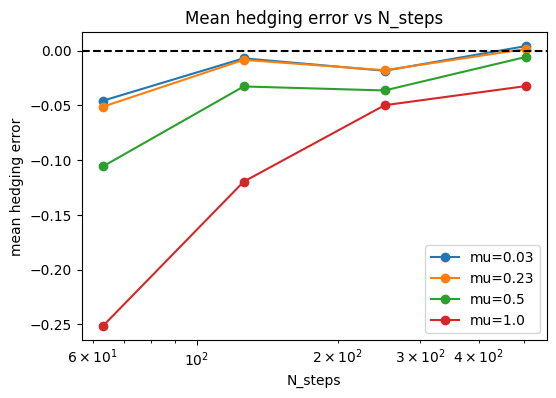

In [8]:
import matplotlib.pyplot as plt

mus = [0.03, 0.23, 0.5, 1.0]
nsteps_list = [63*2**i for i in range(0,4)]
plt.figure(figsize=(6,4))
for mu in mus:
    means = [results_table[mu][n]['mean'] for n in nsteps_list]
    plt.plot(nsteps_list, means, marker='o', label=f"mu={mu}")
plt.axhline(0, color='k', linestyle='--')
plt.xscale('log'); plt.xlabel('N_steps'); plt.ylabel('mean hedging error')
plt.title('Mean hedging error vs N_steps'); plt.legend()
plt.show()

I can also try to hedging under values of $\mu$ that are unrealistically large, to further test my implementation. As we can see, the standard deviations of the hedging errors are huge and sometimes the mean itself is very large.

In [9]:
extreme_mus = [2.0, 3.0, 5.0]  # unrealistic
for mu in extreme_mus:
    out = hedging.delta_hedge(model=m, mu=mu, K=K, T=T, S0=S0,
                              v01=v01, v02=v02, N_paths=20000, N_steps=252, seed=1,
                              quad_rule=quad_rule, quad_params=quad_params)
    hed = out['hedging_error_T']
    print("mu=", mu, "mean=", np.mean(hed), "std=", np.std(hed))

-0.1253054243305683 5.84975024488921
mu= 2.0 mean= -0.1253054243305683 std= 5.84975024488921
-0.048683956050234733 31.078198444392303
mu= 3.0 mean= -0.048683956050234733 std= 31.078198444392303
17.782239984449106 553.228017833551
mu= 5.0 mean= 17.782239984449106 std= 553.228017833551


## Hedging using a mismatched model

This experiment deals with hedging when the assumed model doesn't match the asset dynamics. We assume that the asset follows the dynamics of a Double Heston model with parameters 
$$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and we consider a call option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$.

For hedging I will use the following models:
1. Double Heston model
2. Heston model with volatility equal to $v_1$
3. Heston model with volatility equatl to $v_1+v_2$

Found cached results '../results/hedging_dh_mismatch_results.npz' — checking parameters...
Cached results do not match parameters. Recomputing...

Running N_steps = 63
  Method: Correct(DoubleHeston) ... done. mean=-0.045739, std=2.126140
  Method: Heston_use_V1        ... done. mean=-6.286769, std=3.678853
  Method: Heston_use_sum       ... done. mean=-0.365699, std=2.118789

Running N_steps = 126
  Method: Correct(DoubleHeston) ... done. mean=-0.007004, std=1.639822
  Method: Heston_use_V1        ... done. mean=-6.214456, std=3.376327
  Method: Heston_use_sum       ... done. mean=-0.327022, std=1.625359

Running N_steps = 252
  Method: Correct(DoubleHeston) ... done. mean=-0.018359, std=1.301911
  Method: Heston_use_V1        ... done. mean=-6.231779, std=3.196136
  Method: Heston_use_sum       ... done. mean=-0.337480, std=1.283769

Running N_steps = 504
  Method: Correct(DoubleHeston) ... done. mean=0.004140, std=1.094891
  Method: Heston_use_V1        ... done. mean=-6.237046, std

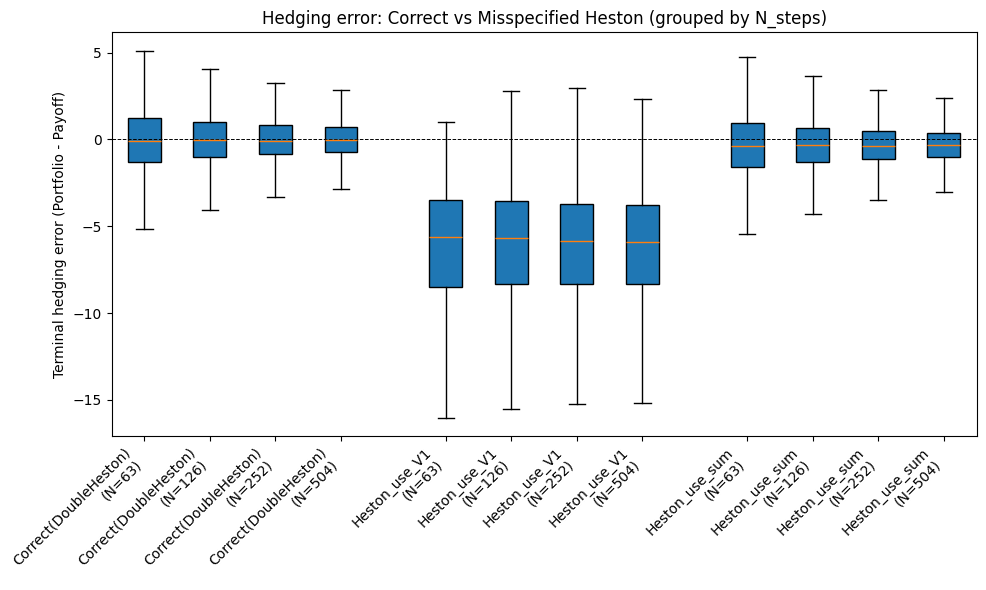

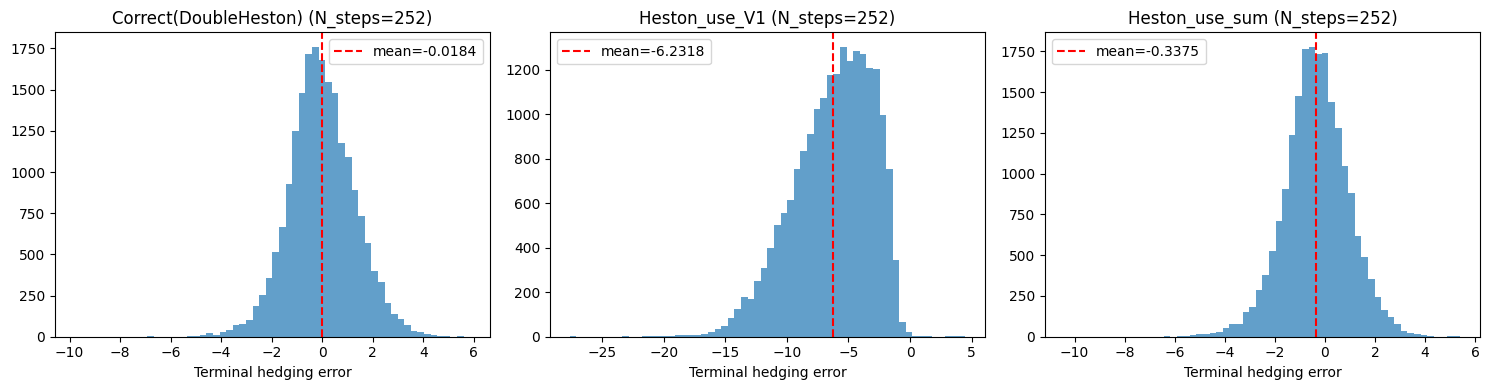


Summary (mean, std) of terminal hedging error:

Method: Correct(DoubleHeston)
  N_steps= 63  mean=-0.045739  std= 2.126140
  N_steps=126  mean=-0.007004  std= 1.639822
  N_steps=252  mean=-0.018359  std= 1.301911
  N_steps=504  mean= 0.004140  std= 1.094891

Method: Heston_use_V1
  N_steps= 63  mean=-6.286769  std= 3.678853
  N_steps=126  mean=-6.214456  std= 3.376327
  N_steps=252  mean=-6.231779  std= 3.196136
  N_steps=504  mean=-6.237046  std= 3.104508

Method: Heston_use_sum
  N_steps= 63  mean=-0.365699  std= 2.118789
  N_steps=126  mean=-0.327022  std= 1.625359
  N_steps=252  mean=-0.337480  std= 1.283769
  N_steps=504  mean=-0.315982  std= 1.068633


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from models.doubleheston import DoubleHeston
from models.heston import Heston
import utils.hedging as hedging

# ----------------------
# Base (true) Double Heston model parameters
# ----------------------
true = DoubleHeston(r=0.03, q=0.0,
                    kappa1=0.9, kappa2=1.2,
                    theta1=0.1, theta2=0.15,
                    sigma1=0.1, sigma2=0.2,
                    rho1=-0.5, rho2=-0.5)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# Quad rule
quad_rule = 'laguerre'
quad_params = {'nodes': 32}

# Simulation / hedging settings
N_paths = 20000
nsteps_list = [63*2**i for i in range(4)]#[50, 100, 200, 500]
seed = 20
chosen_N = nsteps_list[-2] # for histograms / sample paths

# ----------------------
# Build misspecified hedgers
# ----------------------
heston_v1 = Heston(r=true.r, q=true.q,
                   kappa=true.kappa1, theta=true.theta1,
                   sigma=true.sigma1, rho=true.rho1)

heston_sum = Heston(r=true.r, q=true.q,
                    kappa=true.kappa1, theta=true.theta1,
                    sigma=true.sigma1, rho=true.rho1)

methods = {
    'Correct(DoubleHeston)': (true, true, None),
    'Heston_use_V1': (true, heston_v1, 'v1'),
    'Heston_use_sum': (true, heston_sum, 'sum')
}

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "hedging_dh_mismatch_results.npz")

# ----------------------
# Check cached results
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()
    if (cached_params.get('N_paths') == N_paths and
        cached_params.get('nsteps_list') == nsteps_list and
        cached_params.get('seed') == seed):
        print("Cached results match parameters. Loading...")
        comparison = data['comparison'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing...")

# ----------------------
# Delta hedge simulation helper
# ----------------------
def delta_hedge_on_simulated(sim_model, hedge_model, v_choice='sum', mu=None,
                             K=K, T=T, S0=S0, v01=v01, v02=v02,
                             N_paths=N_paths, N_steps=252, seed=0,
                             quad_rule='laguerre', quad_params={'nodes':32}):
    sim_paths = sim_model.simulate_paths(mu=(mu if mu is not None else sim_model.r),
                                         T=T, S0=S0, v01=v01, v02=v02,
                                         N_paths=N_paths, N_steps=N_steps, seed=seed)
    S, V1, V2 = sim_paths

    dt = T / (N_steps - 1)
    Tau = np.tile((N_steps - 1 - np.arange(N_steps)) * dt, (N_paths,1))

    if hasattr(hedge_model, 'model_type') and hedge_model.model_type == 'heston':
        if v_choice == 'v1':
            V_for_hedger = V1
        elif v_choice == 'v2':
            V_for_hedger = V2
        elif v_choice == 'sum':
            V_for_hedger = V1 + V2
        elif v_choice == 'avg':
            V_for_hedger = 0.5*(V1+V2)
        else:
            raise ValueError("v_choice must be 'v1','v2','sum' or 'avg'")
        Greeks = hedge_model.price_greeks_vect(K=K, Tau=Tau, S=S, V=V_for_hedger,
                                              quad_rule=quad_rule, quad_params=quad_params)
    elif hasattr(hedge_model, 'model_type') and hedge_model.model_type == 'doubleheston':
        Greeks = hedge_model.price_greeks_vect(K=K, Tau=Tau, S=S, V1=V1, V2=V2,
                                              quad_rule=quad_rule, quad_params=quad_params)
    else:
        raise ValueError("Unknown hedger model type")

    Price_call = Greeks["Price_call"]
    Delta = Greeks["Delta"]

    r = sim_model.r
    Cash = np.zeros((N_paths, N_steps))
    Portfolio = np.zeros((N_paths, N_steps))

    Cash[:,0] = Price_call[:,0] - Delta[:,0]*S[:,0]
    Portfolio[:,0] = Delta[:,0]*S[:,0] + Cash[:,0]

    for t in range(1, N_steps-1):
        Cash[:,t] = Cash[:,t-1] * np.exp(r*dt)
        Delta_change = Delta[:,t] - Delta[:,t-1]
        Cash[:,t] -= Delta_change * S[:,t]
        Portfolio[:,t] = Delta[:,t]*S[:,t] + Cash[:,t]

    Cash[:,-1] = Cash[:,-2] * np.exp(r*dt)
    Portfolio[:,-1] = Delta[:,-2]*S[:,-1] + Cash[:,-1]

    liability_T = np.maximum(S[:,-1] - K, 0)
    hedging_error_T = Portfolio[:,-1] - liability_T

    return {
        "S": S, "V1": V1, "V2": V2,
        "Price_call": Price_call, "Delta": Delta,
        "Cash": Cash, "Portfolio": Portfolio,
        "liability_T": liability_T, "hedging_error_T": hedging_error_T
    }

# ----------------------
# Run simulation for all methods and N_steps
# ----------------------
if recompute:
    comparison = {mname:{} for mname in methods.keys()}
    for N_steps in nsteps_list:
        print(f"\nRunning N_steps = {N_steps}")
        for mname, (sim_model, hedge_model, v_choice) in methods.items():
            print(f"  Method: {mname:20s} ...", end="", flush=True)
            out = delta_hedge_on_simulated(sim_model=sim_model,
                                           hedge_model=hedge_model,
                                           v_choice=(v_choice if v_choice is not None else 'sum'),
                                           mu=sim_model.r, K=K, T=T, S0=S0,
                                           v01=v01, v02=v02, N_paths=N_paths, N_steps=N_steps,
                                           seed=seed, quad_rule=quad_rule, quad_params=quad_params)
            hed = out['hedging_error_T']
            comparison[mname][N_steps] = {
                'out': out,
                'mean': np.mean(hed),
                'std': np.std(hed),
                'hed_err': hed
            }
            print(f" done. mean={np.mean(hed):.6f}, std={np.std(hed):.6f}")

    # Save results
    params = {'N_paths': N_paths, 'nsteps_list': nsteps_list, 'seed': seed}
    np.savez_compressed(filename, comparison=comparison, params=params)
    print(f"\nHedging misspecification results saved to '{filename}'")

# ----------------------
# Boxplot: compare methods for all N_steps
# ----------------------
fig, ax = plt.subplots(1,1, figsize=(10,6))
positions = []
labels = []
data_to_plot = []
pos = 1
gap = 0.6
for j, mname in enumerate(methods.keys()):
    for idx, N_steps in enumerate(nsteps_list):
        data_to_plot.append(comparison[mname][N_steps]['hed_err'])
        positions.append(pos)
        labels.append(f"{mname}\n(N={N_steps})")
        pos += 1
    pos += gap

bp = ax.boxplot(data_to_plot, positions=positions, tick_labels=labels, patch_artist=True, showfliers=False)
ax.axhline(0, color='k', linestyle='--', linewidth=0.7)
ax.set_ylabel("Terminal hedging error (Portfolio - Payoff)")
ax.set_title("Hedging error: Correct vs Misspecified Heston (grouped by N_steps)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "hedging_dh_mismatch_boxplot.png"), dpi=300)
plt.show()

# ----------------------
# Histograms for chosen_N
# ----------------------
fig, axes = plt.subplots(1, len(methods), figsize=(5*len(methods),4))
if len(methods) == 1:
    axes = [axes]
for ax, (mname, _) in zip(axes, methods.items()):
    hed = comparison[mname][chosen_N]['hed_err']
    ax.hist(hed, bins=60, alpha=0.7)
    ax.axvline(np.mean(hed), color='red', linestyle='--', label=f"mean={np.mean(hed):.4f}")
    ax.set_title(f"{mname} (N_steps={chosen_N})")
    ax.set_xlabel("Terminal hedging error")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_folder, f"hedging_dh_mismatch_hist_N{chosen_N}.png"), dpi=300)
plt.show()

# ----------------------
# Summary table
# ----------------------
print("\nSummary (mean, std) of terminal hedging error:")
for mname in methods.keys():
    print(f"\nMethod: {mname}")
    for N_steps in nsteps_list:
        mean_ = comparison[mname][N_steps]['mean']
        std_ = comparison[mname][N_steps]['std']
        print(f"  N_steps={N_steps:3d}  mean={mean_: .6f}  std={std_: .6f}")

We can see that heding with a Heston model using only one volatility produces a very large negative mean, and that the dispersion of the hedging errors remains large even when rebalancing more often.

The histogram resulting from hedging with a Heston model and volatility equal to the sum of $v_1$ and $v_2$ looks a bit more like the Double Heston counter part but produces a mean that is negative and different from zero.

## Derivation of the discretization

The dynamics of the asset price in the Double Heston model is given by the differential equations $$\begin{align} \frac{d S_t}{S_t} & = r dt + \sqrt{v_t^1} d W_t^1 + \sqrt{v_t^2} dW_t^2 \\
d v_t^1 & = \kappa_1 (\theta_1 - v_t^1) dt + \sigma_1 \sqrt{v_t^1} d Z_t^1 \\
dv_t^2 & = \kappa_2 (\theta_2-v_t^2) dt + \sigma_2 \sqrt{v_t^2} d Z_t^2\end{align} $$ with Brownian motions satisfying
$$ \begin{align} \langle W^1, Z^1 \rangle_t & = \rho_1 t \\
\langle W^2, Z^2 \rangle_t &= \rho_2 t \\
\langle W^1, W^2 \rangle_t &= 0 \\
\langle Z^1, Z^2 \rangle_t &= 0.
\end{align} $$

As indicated in Gauthier and Possamai, the key idea is to start with the logarithm of the discounted asset price. Applying Ito's formula to $f(u,S_u)= \log(e^{-r u} S_u)$ we have that
$$ f(t+dt,S_{t+dt}) = f(t,S_t)  + \int_t^{t+dt} \frac{\partial f}{\partial u} du + \int_t^{t+dt} \frac{df}{dS} dS_u+ \frac{1}{2} \int_t^{t+dt} \frac{\partial^2 f}{\partial S^2} d \langle S, S \rangle_u$$
where $dt$ is not a differential, but a finite increment in $t$. The actual size of $dt$ will depend on how fine we make the discretization for simulation. We then have the equation:
$$ \begin{align} \log (e^{-r(t+dt)} S_{t+dt})) &= \log (e^{-rt} S_t) -\int_t^{t+dt}rdu + \int_t^{t+dt}\frac{1}{S_u}dS_u-\frac{1}{2} \int_t^{t+dt} \frac{1}{S_u^2} d\langle S, S \rangle_u \\
&= \log (e^{-rt} S_t) + \int_t^{t+dt} \sqrt{v_u^1} dW_u^1 + \int_t^{t+dt} \sqrt{v_u^2} dW_u^2 -\frac{1}{2} \int_t^{t+dt} (v_u^1 +v_u^2) du \end{align}$$



Because of the assumptions of the model we have a decomposition
$$\begin{align} W_t^1 = \rho_1 Z_t^1 + \sqrt{1-\rho_1^2} \widetilde{W}_t^1  \\ 
 W_t^2 = \rho_2 Z_t^2 + \sqrt{1-\rho_2^2} \widetilde{W}_t^2 \end{align}$$
 where $\widetilde{W}_t^i$ is a Brownian motion independent from $Z^i$ for $i=1,2$. Substituting into our equation we have that:
 $$\begin{align} \log(e^{-r(t+dt)} S_{t+dt}) & = \log(e^{-rt} S_t) + \int_t^{t+dt} \rho_1 \sqrt{v_u^1} d Z_u^1 + \int_t^{t+dt} \rho_2 \sqrt{v_u^2} d Z_u^2  \\ 
 &+\int_t^{t+dt} \sqrt{1-\rho_1^2} \sqrt{v_u^1} d \widetilde W_u^1 +\int_t^{t+dt} \sqrt{1-\rho_2^2} \sqrt{v_u^2} d \widetilde W_u^2 \\ & -\frac{1}{2} \int_t^{t+dt} (v_u^1 +v_u^2) du\end{align} $$

Next, we use the equations for the variance processes:
$$\begin{align} v_{t+dt}^1 & = v_t^1 + \int_t^{t+dt} \kappa_1 (\theta_1- v_u^1) du + \sigma_1 \int_t^{t+dt} \sqrt{v_u^1} d Z_u^1 \\
v_{t+dt}^2 & = v_t^2 + \int_t^{t+dt} \kappa_2 (\theta_2- v_u^2) du + \sigma_2 \int_t^{t+dt} \sqrt{v_u^2} d Z_u^2\end{align} $$ 
to get
$$\begin{align} \int_t^{t+dt} \sqrt{v_u^1} d Z_u^1 &= \frac{1}{\sigma_1} \left( v_{t+dt}^1 - v_t^1 - \kappa_1 \theta_1 dt + \kappa_1 \int_t^{t+dt} v_u^1 du \right) \\ 
\int_t^{t+dt} \sqrt{v_u^2} d Z_u^2 &= \frac{1}{\sigma_2} \left( v_{t+dt}^2 - v_t^2 - \kappa_2 \theta_2 dt + \kappa_2 \int_t^{t+dt} v_u^2 du \right)\end{align} $$

Substituting into the equation for the logarithm of the discounted price we finally get
$$\begin{align} \log \left( \frac{e^{-r(t+dt)}S_{t+dt}}{e^{-rt} S_t} \right) &= \frac{\rho_1}{\sigma_1} (v_{t+dt}^1-v_t^1 - \kappa_1 \theta_1 dt) + \frac{\rho_2}{\sigma_2} (v_{t+dt}^2-v_t^2 - \kappa_2 \theta_2 dt) \\ &+ \left( \frac{\kappa_1 \rho_1}{\sigma_1} -\frac{1}{2} \right) \int_t^{t+dt} v_u^1 du + \left( \frac{\kappa_2 \rho_2}{\sigma_2} -\frac{1}{2} \right) \int_t^{t+dt} v_u^2 du \\
&+\sqrt{1-\rho_1^2}\int_t^{t+dt}  \sqrt{v_u^1} d \widetilde W_u^1 + \sqrt{1-\rho_2^2}\int_t^{t+dt}  \sqrt{v_u^2} d \widetilde W_u^2 .
\end{align}$$

For the integral of $v_u^j$ against $u$, the standard predictor corrector Euler scheme makes the approximation: $$\int_t^{t+dt} v_u^j du\approx \frac{dt}{2} (v_{t+dt}^j+v_t^j)$$. Now, we consider the stochastic integrals $$ \int_t^{t+dt} \sqrt{v^j} d \widetilde W _u^j. $$ By definition, $v_u^1$ is adapted to $Z_u^j$ and $\widetilde W_u^j$ is independent of $Z_u^j$, so $\sqrt{v_u^j}$ is adapted to the joint filtration. We can apply Ito's isommetry to obtain that, conditionally, $$\int_t^{t+dt}  \sqrt{v_u^j} d \widetilde W_u^j \sim \mathcal{N} \left(0, \int_t^{t+dt} v_u^j du \right). $$ We approximate this integral using the same predictor corrector Euler scheme as before.

Using all these considerations, we have that the scheme for the logarithm of the price is:

$$\begin{align} \log \left(e^{-r(t+dt) } \widehat S_{t+dt}\right) & = \log(e^{-rt} \widehat S_t) + K_0^1 + K_0^2 +K_1^1 \widehat V_t^1 + K_1^2 \widehat V_t^2 + K_2^1 \widehat V_{t+dt}^1 + K_2^2 \widehat V_{t+dt}^2\\ 
& + \sqrt{K_3^1 (\widehat V_t^1 + \widehat V_{t+dt}^1) } B_1 + \sqrt{K_3^2 (\widehat V_t^2 + \widehat V_{t+dt}^2)} B_2,\end{align}$$

where $B_1,B_2 \sim \mathcal{N}(0,1)$ independent of each other and 

$$\begin{align}
K_0^j &= - \frac{\rho_j \kappa_j \theta_j}{\sigma_j} dt \\
K_1^j &= \frac{dt}{2} \left( \frac{\kappa_j \rho_j}{\sigma_j}-\frac{1}{2} \right) - \frac{\rho_j}{\sigma_j} \\
K_2^j &= \frac{dt}{2} \left( \frac{\kappa_j \rho_j}{\sigma_j}-\frac{1}{2} \right) + \frac{\rho_j}{\sigma_j} \\
K_3^j &= \frac{dt}{2}  (1-\rho_j^2).\end{align} $$

For the variance processes we directly use the Euler scheme 
$$\widehat V_{t+dt}^j = \widehat V_t^j + \kappa_j \left( \theta_j - \left( \widehat V_t^j \right)^+ \right) dt + \sigma_j \sqrt{\left( \widehat V_t^j \right)^+} G_j \sqrt{dt}$$
where $G_1, G_2 \sim \mathcal{N}(0,1)$ are independent from each other and from $B_1,B_2$, and we also use the full truncation scheme $\left( \widehat V_t^j \right)^+ = \max \left(\widehat V_t^j, 0 \right)$, that prevents $\widehat V_t^j$ from becoming negative.

To simulate a path, we start with initial price and variances $\widehat S_0, \widehat V_0^1, \widehat V_0^2$, and calculate $\widehat S_{t+dt}, \widehat V_{t+dt}^1, \widehat V_{t+dt}^2$ for every subsequent steps using the relations above. At each time step, the variances should be updated before updating the price.

## References:
- *Efficient Simulation of the Double Heston model*, Gauthier and Possamai (2010).
- *The Heston Model and its Extensions in Matlab and C#*, Rouah (2013).
